# Quantum Approximate Q-learning with Parametrized Quantum Circuits

In this Notebook we are going to implement a Quantum version of the Reinforcement Learning technique called Deep Q-learning, which uses a Deep Neural Network, named *Deep Q-Network* (hence DQN), to approximate the optimal state-action pair Q-values $Q^\ast(s,a)$ characterizing the reinforcement learning task to be solved.  

But since this is a Qiskit's Hackathon, let's throw some quantumness in there! 
In fact, a natural question arise in the mind of a quantum enthusiast: what if we substitute the Deep Neural Network with a quantum parametric circuit, playing the role of a Quantum Neural Network? That's exactly the approach we are going to follow in this notebook, and in particular we are recreating a simplified, yet efficient, version of the algorithm proposed by Skolik et al [[1]](#1), but written entirely in Qiskit! 

For this project, we will be using the brand new Qiskit Machine Learning [[2]](#2) module to create the quantum neural network and iterface it with PyTorch [[3]](#3) using Qiskit's `TorchConnector` to use fast and seamless evaluation of gradients! At last, we connect this setup with the `CartPole` environment created using OpenAI `gym` [[4]](#4), an open-source library for Reinforcement Learning.  

Without further ado, let's code! 

---
### References

<a id="1">[1]</a> 
Andrea Skolik, Sofiene Jerbi and Vedran Dunjko (2019), *Quantum agents in the Gym: a variational quantum algorithm for deep Q-learning*, [arXiv:2103.15084](https://arxiv.org/abs/2103.15084).

<a id="2">[2]</a> 
IBM, Qiskit Quantum Machine Learning repository, [GitHub](https://github.com/Qiskit/qiskit-machine-learning).

<a id="3">[3]</a> 
Adam Paszke, Sam Gross, Soumith Chintala, Gregory Chanan, Edward Yang, Zachary DeVito, Zeming Lin, Alban Desmaison, Luca Antiga,  and Adam Lerer (2017), *Automatic differentiation in PyTorch*, NIPS-W. PyTorch [Website](https://pytorch.org/), [GitHub](https://github.com/pytorch/pytorch).

<a id="4">[4]</a> 
OpenAI [Website](https://openai.com/), [Github](https://github.com/openai/gym).

#### Import of relevant packages

In [8]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit Circuit imports
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import TwoLocal

# Qiskit imports
import qiskit as qk
from qiskit.utils import QuantumInstance

# Qiskit Machine Learning imports
import qiskit_machine_learning as qkml
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.connectors import TorchConnector

# PyTorch imports
import torch
from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD, Adam, RMSprop

# OpenAI Gym import
import gym

# Fix seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed);

# To get smooth animations on Jupyter Notebooks. 
# Note: these plotting function are taken from https://github.com/ageron/handson-ml2
import matplotlib as mpl
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

## Definition of the *Parametrized Quantum Circuit* (PQC)  

The first step in our Quantum Reinforcement Learning journey with quantum neural networks, is to choose the specific structure of the quantum circuit.  

In particular, we need two things: first, a way to encode classical data into a quantum circuit, second a parametrized variational circuit, which is the trainable part of the quantum neural network that we optimize to solve the reinforcement learning task. As said previously, we implement the same structure proposed in [[1]](#1).  

So, we define the following two functions, `encoding_circuit` and  `parametrized_circuit`, each implementing one of the two steps above.

##### `encoding_circuit`

This function is used to load on the circuit the classical inputs. In our case, the inputs are the state variables of the `CartPole` environment, which consists of an array of 4 numbers, i.e. the state of the system is given by $\vec{s} \in \mathbb{R}^4$. These features are encoded on a quantum register of 4 qubits initized in zero $|0000\rangle$ by means of $R_x$ rotations.

####  `parametrized_circuit`  

This function creates the full parametrized quantum circuit, given by econding plus variational ansatz. The variational ansatz consists of a repeated structure of $R_y$ and $R_z$ rotations, followed by a circular entagling scheme made of $CZ$ gates. It is possible to choose the number of repetitions (*layers*) in the variational quantum circuit, as well as wether to use *data reuploading*, i.e. loading again the classical data at the start of each new layer, in order to increase the circuit's expressivity (see [[1]](#1) for further details).  
Both inputs and weights (trainable parameters) are created as Qiskit's `Parameters`.

In [9]:
def encoding_circuit(inputs, num_qubits = 4, *args):
    """
    Encode classical input data (i.e. the state of the enironment) on a quantum circuit. 
    To be used inside the `parametrized_circuit` function. 
    
    Args
    -------
    inputs (list): a list containing the classical inputs.
    num_qubits (int): number of qubits in the quantum circuit.
    
    Return
    -------
    qc (QuantumCircuit): quantum circuit with encoding gates.
    
    """
    
    qc = qk.QuantumCircuit(num_qubits)
    
    # Encode data with a RX rotation
    for i in range(len(inputs)): 
        qc.rx(inputs[i], i)
        
    return qc

def parametrized_circuit(num_qubits = 4, reuploading = False, reps = 2, insert_barriers = True, meas = False):
    """
    Create the Parameterized Quantum Circuit (PQC) for estimating Q-values.
    It implements the architecure proposed in Skolik et al. arXiv:2104.15084.
    
    Args
    -------
    num_qubit (int): number of qubits in the quantum circuit. 
    reuploading (bool): True if want to use data reuploading technique.
    reps (int): number of repetitions (layers) in the variational circuit. 
    insert_barrirerd (bool): True to add barriers in between gates, for better drawing of the circuit. 
    meas (bool): True to add final measurements on the qubits. 
    
    Return
    -------
    qc (QuantumCircuit): the full parametrized quantum circuit. 
    """
    
    qr = qk.QuantumRegister(num_qubits, 'qr')
    qc = qk.QuantumCircuit(qr)
    
    if meas:
        qr = qk.QuantumRegister(num_qubits, 'qr')
        cr = qk.ClassicalRegister(num_qubits, 'cr')
        qc = qk.QuantumCircuit(qr,cr)
    
    
    if not reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
                
        # Encode classical input data
        qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Variational circuit
        qc.compose(TwoLocal(num_qubits, ['ry', 'rz'], 'cz', 'circular', 
               reps=reps, insert_barriers= insert_barriers, 
               skip_final_rotation_layer = True), inplace = True)
        if insert_barriers: qc.barrier()
        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    elif reuploading:
        
        # Define a vector containg Inputs as parameters (*not* to be optimized)
        inputs = qk.circuit.ParameterVector('x', num_qubits)
                
        # Define a vector containng variational parameters
        θ = qk.circuit.ParameterVector('θ', 2 * num_qubits * reps)
        
        # Iterate for a number of repetitions
        for rep in range(reps):

            # Encode classical input data
            qc.compose(encoding_circuit(inputs, num_qubits = num_qubits), inplace = True)
            if insert_barriers: qc.barrier()
                
            # Variational circuit (does the same as TwoLocal from Qiskit)
            for qubit in range(num_qubits):
                qc.ry(θ[qubit + 2*num_qubits*(rep)], qubit)
                qc.rz(θ[qubit + 2*num_qubits*(rep) + num_qubits], qubit)
            if insert_barriers: qc.barrier()
                
            # Add entanglers (this code is for a circular entangler)
            qc.cz(qr[-1], qr[0])
            for qubit in range(num_qubits-1):
                qc.cz(qr[qubit], qr[qubit+1])
            if insert_barriers: qc.barrier()
                        
        # Add final measurements
        if meas: qc.measure(qr,cr)
        
    return qc

### Create the PQC  

We can use the functions just defined to create the Parametrized Quantum Circuit:

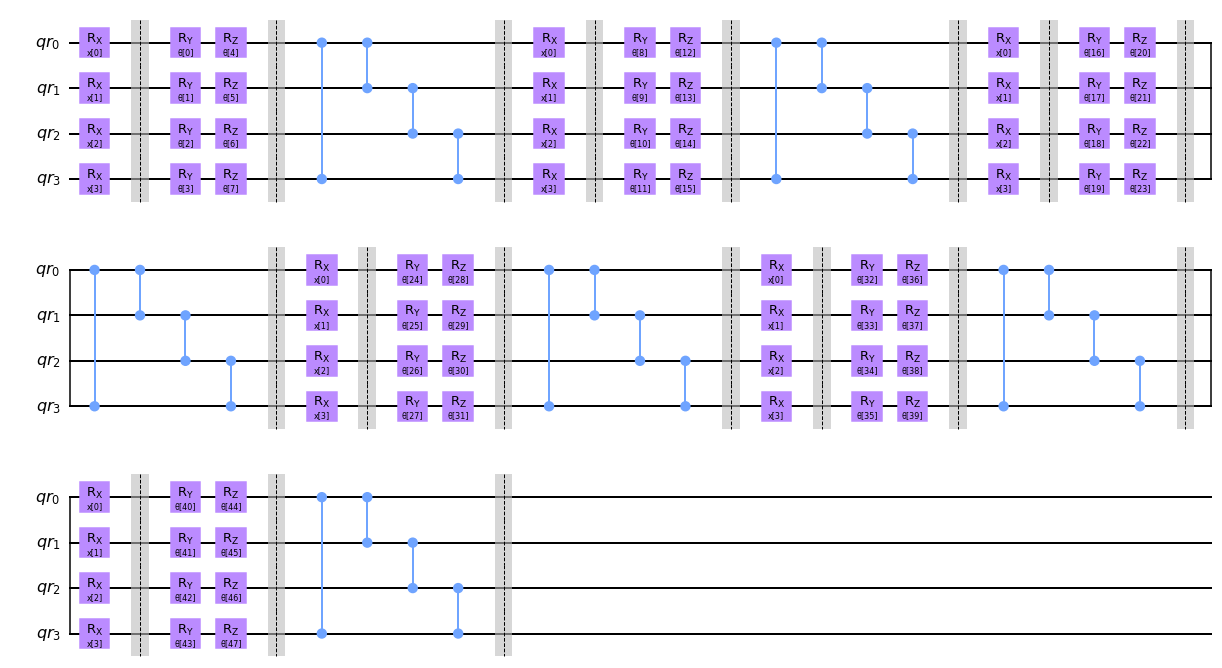

In [10]:
# Select the number of qubits
num_qubits = 4

# Generate the Parametrized Quantum Circuit (note the flags reuploading and reps)
qc = parametrized_circuit(num_qubits = num_qubits, 
                          reuploading = True, 
                          reps = 6)

# Fetch the parameters from the circuit and divide them in Inputs (X) and Trainable Parameters (params)
# The first four parameters are for the inputs 
X = list(qc.parameters)[: num_qubits]

# The remaining ones are the trainable weights of the quantum neural network
params = list(qc.parameters)[num_qubits:]

qc.draw()

### Create a `PyTorch` layer  

We can sse Qiskit's brand new `CircuitQNN` and `TorchConnector` functionalities to create a `PyTorch` model from the parametrized quantum circuit: 

In [11]:
# Select a quantum backend to run the simulation of the quantum circuit
qi = QuantumInstance(qk.Aer.get_backend('statevector_simulator'))

# Create a Quantum Neural Network object starting from the quantum circuit defined above
qnn = CircuitQNN(qc, input_params=X, weight_params=params, 
                 quantum_instance = qi)

# Connect to PyTorch
initial_weights = (2*np.random.rand(qnn.num_weights) - 1)
quantum_nn = TorchConnector(qnn, initial_weights)

## Classical pre- and post-processing layers  

In order for the model to function properly, classical pre- and post-processing layers are needed. Both of these will contains parameters hence will be trainable and optimized duirng the draining of the model.  

We define such layers as classes inheriting from `PyTorch`'s `torch.nn.Module`.  

#### `encoding_layer`  (not to be confused with the quantum encoding circuit)

First, we define the classical pre-processing (*encoding*) layer, which takes the classical inputs $\vec{s}= (s_0, s_1, s_2, s_3)$, multiplies them by a trainable parameters $\vec{w}= (w_0, w_1, w_2, w_3)$, and then applies an $\arctan$ on it, thus leading to the overall mapping:  

$$ 
\vec{s} \rightarrow \vec{s}' = (s'_0, s'_1, s'_2, s'_3)\quad
{\rm{with}}\quad s'_i = \arctan(w_i \cdot s_i)\, .
$$  

In [12]:
class encoding_layer(torch.nn.Module):
    def __init__(self, num_qubits = 4):
        super().__init__()
        
        # Define weights for the layer
        weights = torch.Tensor(num_qubits)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, -1, 1) # <--  Initialization strategy
    
        
    def forward(self, x):
        """Forward step, as explained above."""
        
        if not isinstance(x, Tensor):
            x = Tensor(x)
        
        x = self.weights * x
        x = torch.atan(x)
                
        return x

#### `exp_val_layer`
Then, we create the classical post-processing layer, which takes as input the output of the quantum circuit $\vec{p} = (p_0, p_1,\cdots, p_{15})$, consisting of the probability vector of size $2^{\rm n\_qubits}$ (one entry per computational basis' state).  
> Using Qiskit's ordering of the qubits, $p_0$ corresponds to the probability of measuring state $|0000\rangle$, $p_1$ probability of measuring state $|0001\rangle$, and so on up until $p_{15}$, corresponding to the probability of measuring $|1111\rangle$.   

Given these probabilities, the `exp_val_layer` evaluates the expectation values $\langle Z_0 Z_1\rangle$ and $\langle Z_2 Z_3\rangle$, corresponding to the Q-values $Q(s,a)$ of the two possible actions $a$: "*left*" or "*right*". At last, these values are shifted in $[0,1]$ and multiplied by a trainable weight each. 

#### More in detail... 
The math behind this layer is as follows. Be $O_a$ the operator corresponding to action $a$, which are taken to be $O_{\rm left} = Z_0 Z_1$ and $O_{\rm right} = Z_2 Z_3$.  
> By $Z_0 Z_1$ we mean the Pauli Operator $Z$ acting of qubits '0' and '1', and identities on the other qubits, i.e the operator $Z_0 Z_1 \leftarrow Z_0 \otimes Z_1 \otimes \mathbb{1}_2 \otimes \mathbb{1}_3$. Same goes for $Z_3 Z_4$.  

The Q-values $Q(s, a)$ of action $a$ given a state $s$ is given by:

$$
Q(s, a) = w_{a}\cdot \frac{\langle \boldsymbol{0} | U_{\theta}(\vec{s})^\dagger O_a U_{\theta}(\vec{s}) |\boldsymbol{0}\rangle +1}{2}
$$

where $U_{\theta}(\vec{s})$ denotes the quantum neural network (which is a function of the input state $s$ and of the variational parameters $\theta$), and $w_a$ denotes a new trainable weight, one for each of the actions. 

Thus, the final output of the `exp_val_layer` consists of the pair of Q-values: $\big[Q(s, a = {\rm left}),\, Q(s, a = {\rm right})\big]$. 

In order to go from the vector of probabilities $\vec{p}$ to the expectation values $\langle Z_0 Z_1\rangle$ and $\langle Z_2 Z_3\rangle$, one can do the following.  
Be $|\psi\rangle = U_{\theta}(\vec{s})|0000\rangle$ the state created by the Parametrized Quantum Circuit, on which we want to evaluate the expectation vales. Then  

$$
\langle Z_j Z_k\rangle = \langle \psi |Z_j Z_k \mathbb{1}|\psi\rangle = \sum_{i = 0}^{15} \langle \psi |\underbrace{Z_j Z_k |i\rangle}_{ = f_{kj}(i)|i\rangle}\langle i |\psi\rangle = \sum_{i=0}^{15}f_{kj}(i)|\langle i | \psi \rangle |^2 = \sum_{i=0}^{15}f_{jk}(i) \cdot p_i\,
$$

where $f_{jk}(i)$ is given by  

$$
Z_j Z_k |i\rangle = Z_j Z_k |i_3 i_2 i_1 i_0\rangle = (-)^{i_j}(-)^{i_k}|i_3 i_2 i_1 i_0\rangle = (-)^{i_j+i_k}|i\rangle \quad \big(\text{NOTE: Qiskit ordering is being used!}\big)\\
\implies \langle Z_j Z_k\rangle = \sum_{i} (-)^{i_j + i_k} p_i
$$

One can check manually that (using `Qiskit` *little endian* ordering of the qubits):  

$$
Z_0 Z_1 \rightarrow \vec{f}_{01} = (1,-1,-1,1,1,-1,-1,1,1,-1,-1,1,1,-1,-1,1)\\
Z_2 Z_3 \rightarrow \vec{f}_{23} = (-1,-1,-1,-1,1,1,1,1,-1,-1,-1,-1,1,1,1,1)
$$


In [13]:
class exp_val_layer(torch.nn.Module):
    def __init__(self, action_space = 2):
        super().__init__()
        
        # Define the weights for the layer
        weights = torch.Tensor(action_space)
        self.weights = torch.nn.Parameter(weights)
        torch.nn.init.uniform_(self.weights, 35, 40) # <-- Initialization strategy (heuristic choice)
        
        # Masks that map the vector of probabilities to <Z_0*Z_1> and <Z_2*Z_3>
        self.mask_ZZ_12 = torch.tensor([1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.,1.,-1.,-1.,1.], requires_grad = False)
        self.mask_ZZ_34 = torch.tensor([-1.,-1.,-1.,-1.,1.,1.,1.,1.,-1.,-1.,-1.,-1.,1.,1.,1.,1.], requires_grad = False)
        
    def forward(self, x):
        """Forward step, as described above."""
        
        expval_ZZ_12 = self.mask_ZZ_12 * x
        expval_ZZ_34 = self.mask_ZZ_34 * x
        
        # Single sample
        if len(x.shape) == 1:
            expval_ZZ_12 = torch.sum(expval_ZZ_12)
            expval_ZZ_34 = torch.sum(expval_ZZ_34)
            out = torch.cat((expval_ZZ_12.unsqueeze(0), expval_ZZ_34.unsqueeze(0)))
        
        # Batch of samples
        else:
            expval_ZZ_12 = torch.sum(expval_ZZ_12, dim = 1, keepdim = True)
            expval_ZZ_34 = torch.sum(expval_ZZ_34, dim = 1, keepdim = True)
            out = torch.cat((expval_ZZ_12, expval_ZZ_34), 1)
                
        return self.weights * ((out + 1.) / 2.)

## Quantum Deep Q-network  

We now have all the necessary ingredients to build the full hybrid quantum-classical neural network, which will be trained to solve the `CartPole` environment. 

### Final model  

We construct the final hybrid classical-quantum neural network by stacking together the three layers:  
`model` = `encoding_layer` --> `quantum_layer` --> `exp_val_layer`

In [14]:
# Classical trainable preprocessing
encoding = encoding_layer()

# Classical trainable postprocessing
exp_val = exp_val_layer()

# Stack the classical and quantum layers together 
model = torch.nn.Sequential(encoding, 
                            quantum_nn, 
                            exp_val)

model.state_dict()

OrderedDict([('0.weights', tensor([ 0.7645,  0.8300, -0.2343,  0.9186])),
             ('1._weights',
              tensor([-0.2509,  0.9014,  0.4640,  0.1973, -0.6880, -0.6880, -0.8838,  0.7324,
                       0.2022,  0.4161, -0.9588,  0.9398,  0.6649, -0.5753, -0.6364, -0.6332,
                      -0.3915,  0.0495, -0.1361, -0.4175,  0.2237, -0.7210, -0.4157, -0.2673,
                      -0.0879,  0.5704, -0.6007,  0.0285,  0.1848, -0.9071,  0.2151, -0.6590,
                      -0.8699,  0.8978,  0.9313,  0.6168, -0.3908, -0.8047,  0.3685, -0.1197,
                      -0.7559, -0.0096, -0.9312,  0.8186, -0.4824,  0.3250, -0.3766,  0.0401])),
             ('2.weights', tensor([36.9522, 38.0045]))])

If you want don't want to train the model youself (also because it takes extremely long, ~24h), you can load pre-trained weights with (decomment the cell first):

In [ ]:
# Load pre-trained weights (check if the file exists):
# try:
#     model.load_state_dict(torch.load("./model_best_weights_6reps_longtrain.pth"))
# except: 
#     print("No pre-trained weights found. Looks like you have to train from scratch...")

#### Fully classical model  

As a comparison, you may want to see how of a fully classical neural network performs at this task.  
You don't have to change a single line in the following code, except for decommenting and exectuing the following cell. In fact, note the quantum and classical networks are both called `model`.

In [ ]:
# Decomment and execute the following lines to create a fully classical neural network, instead of the quantum one

# model = torch.nn.Sequential(torch.nn.Linear(4,32),
#                             torch.nn.ELU(),
#                             torch.nn.Linear(32,32),
#                             torch.nn.ELU(),
#                             torch.nn.Linear(32,2))

# Print the weights of the classical neural network
# model.state_dict()

# Print the total number of weights in the classical neural network
# pytorch_total_params = sum(p.numel() for p in model.parameters())

#### Create the `CartPole` environment 

Let's use OpenAI's `gym` library to crete the Reinforcement Learning environment, in particular `CartPole-v1`:

In [15]:
env = gym.make("CartPole-v1")
input_shape = [4] # == env.observation_space.shape
n_outputs = 2 # == env.action_space.n

### Training Functions  

Ok, so we have the environment and we have a quantum-classical neural network, but how the heck are we going to actually train the quantum agent?  

The training algortihm used is classical Deep Q-Learning, but with the substitution of the classical net, with a quantum one. The main idea is to first let the agent behave randomly, so that it *explores* the environment and accumulate some experiences in memory. Then, wo go through an *exploitation* phase, where the agent learns from the past experiences to solve the environment. Technically, as time goes by, the agent makes more and more accurate estimates of the optimal Q-values $Q^\ast(s,a)$, eventually finding an optimal policy for balancing the pole. This explanation is super qualitative and sketchy, and if you're not familiar with RL, you may want to read some theory of Q-learning.   

Alternatively, just run the code and be happy. 

We now proceed writing the functions for the Approximate Q-Learning algorithm. These are based on the implementation found here: https://github.com/ageron/handson-ml2

This code is used to store memories of the past experiences for the agents, which are used during the training of the agent.

In [16]:
from collections import deque

replay_memory = deque(maxlen=2000)

In [17]:
def epsilon_greedy_policy(state, epsilon=0):
    """Manages the transition from the *exploration* to *exploitation* phase"""
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        with torch.no_grad():
            Q_values = model(Tensor(state)).numpy()
        return np.argmax(Q_values[0])
    
def sample_experiences(batch_size):
    """Sample some past experiences from the replay memory"""
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

def play_one_step(env, state, epsilon):
    """Perform one action in the environment and register the state of the system"""
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

def sequential_training_step(batch_size):
    """
    Actual training routine. Implements the Deep Q-Learning algorithm.
    
    This implementation evaluates individual losses sequentially instead of using batches. 
    This is due to an issue in the TorchConnector, which yields vanishing gradients if it 
    is called with a batch of data (see https://github.com/Qiskit/qiskit-machine-learning/issues/100).
    
    Use this training for the quantum model. If using the classical model, you can use indifferently 
    this implementation or the batched one below. 
    """
    
    # Sample past experiences 
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluates Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards + (1 - dones) * discount_rate * max_next_Q_values)
    
    # Accumulate Loss sequentially (if batching data, gradients of the parameters are vanishing)
    loss = 0.
    for j, state in enumerate(states):
        single_Q_value = model(Tensor(state))
        Q_value = single_Q_value[actions[j]]
        loss += (target_Q_values[j] - Q_value)**2
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

def training_step(batch_size):
    """
    This is exactly the same function as sequential_training_step, except that it 
    evaluates loss with batch of data, instead of using a for loop. 
    
    Can use this if training the classical model.
    """
    
    # Sample past experiences
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    
    # Evaluate Target Q-values
    with torch.no_grad():
        next_Q_values = model(Tensor(next_states)).numpy()
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = torch.nn.functional.one_hot(Tensor(actions).long(), n_outputs)
    
    # Evaluate the loss
    all_Q_values = model(Tensor(states))
    Q_values = torch.sum(all_Q_values * mask, dim=1, keepdims=True)
    loss = loss_fn(Tensor(target_Q_values), Q_values)
    
    # Evaluate the gradients and update the parameters 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#### Define hyperparameters  

Define some hyperparameters used in training:

In [18]:
batch_size = 16
discount_rate = 0.99
optimizer = Adam(model.parameters(), lr=1e-2)

## Unleash Elliot, the quantum agent  

We now are really ready to unleash Elliot, the quantum agent, to learn its way to solve the `CartPole` environment. 

Note that the **training is very computationally intensive, and in our simulations it took ~24h to complete**. Unless you really want to train the agent yourself, you can load the pre-trained weights in the model (see cells above, or below) and just enjoy the trained agent. Otherwise, you can let the agent train for few episodes only (start with few hundreds) to get the gist of it. 

In [30]:
rewards = [] 
best_score = 0

# We let the agent train for 2000 episodes
for episode in range(2000):
    
    # Run enviroment simulation
    obs = env.reset()  
    
    # 200 is the target score for considering the environment solved
    for step in range(200):
        
        # Manages the transition from exploration to exploitation
        epsilon = max(1 - episode / 1500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    
    # Saving best agent
    if step >= best_score:
        # torch.save(model.state_dict(), './new_model_best_weights.pth') # Save best weights
        best_score = step
        
    print("\rEpisode: {}, Steps : {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    
    # Start training only after some exploration experiences  
    if episode > 20:
        sequential_training_step(batch_size)

Episode: 1999, Steps : 200, eps: 0.010

Let's see the final optimized  weights of the agent:

In [ ]:
# DECOMMENT IF WANT TO LOAD PRETRAINED WEIGHTS
# Load pre-trained weights (check if the file exists):
# try:
#     model.load_state_dict(torch.load("./model_best_weights_6reps_longtrain.pth"))
# except: 
#     print("No pre-trained weights found. Looks like you have to train from scratch...")

model.state_dict()

And we can plot the total rewards obtained by the quantum agent. The closer to 200 (which is the maximum for the `Cartpole` environment), the better.

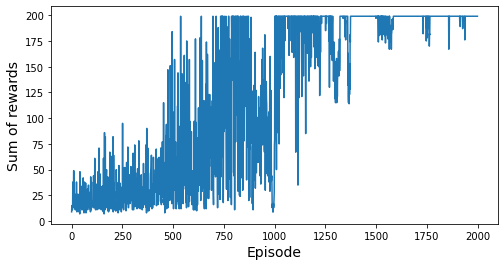

In [31]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

Here is a nice plot of the final rewards from a previous training run

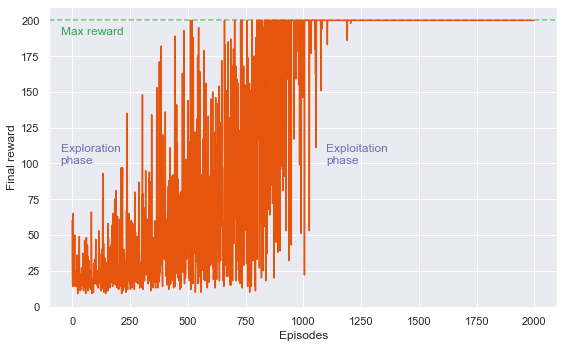

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# This file contains the sum of rewards from a previous successfull training run
rewards_history = np.loadtxt("training_rewards2.txt") + 1

cmap = plt.get_cmap('tab20c')

fig = plt.figure(figsize=(8,5))
plt.axhline([200], ls = 'dashed', c=cmap(9))
plt.text(-50,190, s='Max reward', c=cmap(8))

plt.text(-50,100, s='Exploration\nphase', c=cmap(12))
plt.text(1100,100, s='Exploitation\nphase', c=cmap(12))

plt.plot(rewards_history, c = cmap(4))
plt.xlabel("Episodes")
plt.ylabel("Final reward")

plt.tight_layout()
plt.show()

### Let's see Elliot play

We can use the following cell to create an animation of the quantum agent solving the CartPole environment. 

> **Note for rendering the animation**  
There may be problem running this cell in a Jupyter Notebook, since OpenAI's `env.render` command opens a new window and cause the Notebook's kernel to die if such new window is closed. The suggested solution is to let the new window open but then ignore it, and come back to this Notebook to see the animation generated here (it takes ~10s seconds to output the animation, so don't worry and just wait). Then, only when you are done with this Notebook, you can safely close the external window. Unfortunately, this is a well-known problem of rendering OpenAI animations on a server, and we couldn't find a proper way to circumvent the issue, since it is higlhy dependant on the libraries' versions, as well as on the Operating System.

In [32]:
# Set the environment seed for reproducibility 
env.seed(42)

state = env.reset()

frames = []
for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        print("End at step:", step)
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
plot_animation(frames)

## Hurray!  🎉🎉

We have succesfully solved a Reinforcement Learning task usig a Quantum Neural Network!  

Our Quantum agent, Elliot, used an hybrid combination of classical operations and parametrized quantum circuits to implement the Deep Q-Learning algorithm, and thus solve the `CartPole` environment provided by OpenAI `gym`.  
The whole quantum workflow was built using Qiskit's brand new `Qiskit Machine Learning` module, and together with `PyTorch` we could easily build the the hybrid quantum-classical neural network and leverage seamless evaluation of gradients using backpropagation.

Up to now, we run perfect simulation of the quantum circuits using the `statevector_simulator`, which gives direct access to the amplitudes of the quantum states. What happens if we instead use a more realistic model, for example including noise from stochastic measurement outcomes?  
To answer this question, go check the other Notebook "Quantum Deep Q-Learning: analysis and results " in this repository!

#### What's next?   

There are multiple ways to expand this project, and we leave here some suggestions:  

* apply this model to other control problems available in the OpenAI `gym`;  
* explore other variational ansatzes and encoding schemes, and see how they impacts performances;
* modify the hyperparameters or the training functions, to allow for a faster training routine;
* explore other ways to update the parameters in the circuit (for example using parameter-shift role);
* and much, much more!  

⚛️ 🤖 Quantum Elliot says Hi!